In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet50/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816192835.jpg
/kaggle/input/resnet50/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816204543(1).jpg
/kaggle/input/resnet50/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816200501.jpg
/kaggle/input/resnet50/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816194437.jpg
/kaggle/input/resnet50/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816194409.jpg
/kaggle/input/resnet50/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816203810.jpg
/kaggle/input/resnet50/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816200735.jpg
/ka

In [36]:
!pip install torchinfo

In [37]:

import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


**Path:**

In [38]:

DATA_DIR = "/kaggle/input/resnet50"
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

**Configuration:**

In [39]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


**Seed Value:**

In [40]:

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**Inspect dataset and class name:**

In [41]:

from pathlib import Path
p = Path(DATA_DIR)
if not p.exists():
    raise FileNotFoundError(f"Dataset path not found: {DATA_DIR}")

folders = [f.name for f in p.iterdir() if f.is_dir()]
print("Found class folders:", folders)


Found class folders: ['Leaf that not to be used to make tea-20251023T175713Z-1-001', 'Leaf that uses to make tea-20251023T175715Z-1-001']


**Transform and ImageFolder**

In [42]:

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std= [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std= [0.229, 0.224, 0.225])
])

**Load dataset with ImageFolder:**

In [43]:
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
orig_class_names = full_dataset.classes
print("Original classes (ImageFolder):", orig_class_names)

Original classes (ImageFolder): ['Leaf that not to be used to make tea-20251023T175713Z-1-001', 'Leaf that uses to make tea-20251023T175715Z-1-001']


In [44]:

total_len = len(full_dataset)

train_len = int(0.7 * total_len) 
val_len   = int(0.2 * total_len)  
test_len  = total_len - train_len - val_len 

if val_len == 0:
    val_len = int(0.5 * (total_len - train_len))
    test_len = total_len - train_len - val_len


train_set, val_set, test_set = random_split(
    full_dataset, 
    [train_len, val_len, test_len], 
    generator=torch.Generator().manual_seed(SEED)
)


class SubsetWithTransform(Subset):
    def __init__(self, dataset, indices, transform):
        super().__init__(dataset, indices)
        self.transform = transform

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        path, label = self.dataset.samples[actual_idx]
        from PIL import Image
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = SubsetWithTransform(full_dataset, train_set.indices, train_transform)
val_dataset   = SubsetWithTransform(full_dataset, val_set.indices, val_test_transform)
test_dataset  = SubsetWithTransform(full_dataset, test_set.indices, val_test_transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Total images: {total_len}  Train: {len(train_dataset)}  Val: {len(val_dataset)}  Test: {len(test_dataset)}")


Total images: 747  Train: 522  Val: 149  Test: 76


**Prepare short class name:**

In [45]:

def clean_name(s):
    # remove timestamps and long suffixes, keep first 6-8 words or characters
    s = s.replace('_', ' ')
    tokens = s.split()
    if len(tokens) > 6:
        s = " ".join(tokens[:6]) + "..."
    if len(s) > 24:
        s = s[:21] + "..."
    return s

class_names_short = [clean_name(c) for c in orig_class_names]
print("Short class names:", class_names_short)


Short class names: ['Leaf that not to be u...', 'Leaf that uses to mak...']


**Model setup:**

In [46]:

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(orig_class_names))  

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # optional
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Training:**

In [48]:

epochs = 20 
history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] Training", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()
        total_samples += inputs.size(0)

    train_epoch_loss = running_loss / total_samples
    train_epoch_acc  = running_corrects / total_samples

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels).item()
            val_samples += inputs.size(0)

    val_epoch_loss = val_loss / val_samples
    val_epoch_acc  = val_corrects / val_samples

        scheduler.step()

    # Logging
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(train_epoch_loss)
    history["train_acc"].append(train_epoch_acc)
    history["val_loss"].append(val_epoch_loss)
    history["val_acc"].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_epoch_loss:.4f} Train Acc: {train_epoch_acc*100:.2f}% | "
          f"Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc*100:.2f}%")


Epoch 1/20 | Train Loss: 0.1014 Train Acc: 96.17% | Val Loss: 0.0948 Val Acc: 95.97%


Epoch 2/20 | Train Loss: 0.0352 Train Acc: 99.04% | Val Loss: 0.0574 Val Acc: 97.32%


Epoch 3/20 | Train Loss: 0.0296 Train Acc: 98.85% | Val Loss: 0.0277 Val Acc: 99.33%


Epoch 4/20 | Train Loss: 0.0277 Train Acc: 99.04% | Val Loss: 0.0362 Val Acc: 98.66%


Epoch 5/20 | Train Loss: 0.0251 Train Acc: 99.23% | Val Loss: 0.0273 Val Acc: 99.33%


Epoch 6/20 | Train Loss: 0.0194 Train Acc: 99.43% | Val Loss: 0.0263 Val Acc: 98.66%


Epoch 7/20 | Train Loss: 0.0256 Train Acc: 98.85% | Val Loss: 0.0325 Val Acc: 98.66%


Epoch 8/20 | Train Loss: 0.0189 Train Acc: 99.62% | Val Loss: 0.0597 Val Acc: 98.66%


Epoch 9/20 | Train Loss: 0.0351 Train Acc: 98.66% | Val Loss: 0.0215 Val Acc: 99.33%


Epoch 10/20 | Train Loss: 0.0236 Train Acc: 99.23% | Val Loss: 0.0707 Val Acc: 98.66%


Epoch 11/20 | Train Loss: 0.0378 Train Acc: 98.47% | Val Loss: 0.0147 Val Acc: 99.33%


Epoch 12/20 | Train Loss: 0.0156 Train Acc: 99.81% | Val Loss: 0.0585 Val Acc: 98.66%


Epoch 13/20 | Train Loss: 0.0276 Train Acc: 98.85% | Val Loss: 0.0399 Val Acc: 98.66%


Epoch 14/20 | Train Loss: 0.0226 Train Acc: 99.43% | Val Loss: 0.0393 Val Acc: 98.66%


Epoch 15/20 | Train Loss: 0.0350 Train Acc: 98.85% | Val Loss: 0.0307 Val Acc: 99.33%


Epoch 16/20 | Train Loss: 0.0314 Train Acc: 98.85% | Val Loss: 0.0514 Val Acc: 98.66%


Epoch 17/20 | Train Loss: 0.0290 Train Acc: 99.23% | Val Loss: 0.0283 Val Acc: 99.33%


Epoch 18/20 | Train Loss: 0.0393 Train Acc: 98.85% | Val Loss: 0.0400 Val Acc: 98.66%


Epoch 19/20 | Train Loss: 0.0293 Train Acc: 99.43% | Val Loss: 0.0494 Val Acc: 97.99%


Epoch 20/20 | Train Loss: 0.0554 Train Acc: 98.47% | Val Loss: 0.0240 Val Acc: 98.66%


**Plot of Loss and Accuracy curves:**

Saved training history CSV to /kaggle/working


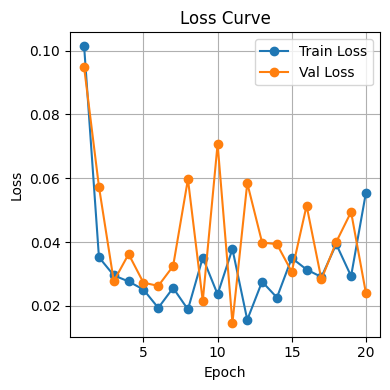

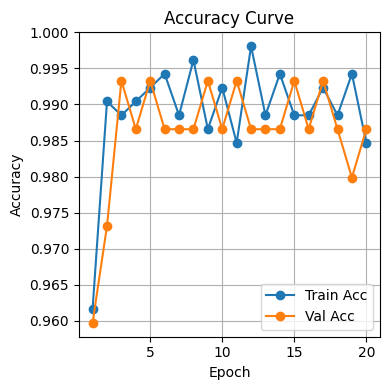

In [59]:

hist_df = pd.DataFrame(history)
hist_df.to_csv(os.path.join(OUTPUT_DIR, "training_history.csv"), index=False)
print("Saved training history CSV to", OUTPUT_DIR)

# Plot Loss
plt.figure(figsize=(4,4))
plt.plot(hist_df['epoch'], hist_df['train_loss'], marker='o', label='Train Loss')
plt.plot(hist_df['epoch'], hist_df['val_loss'], marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "loss_curve.png"))
plt.show()

# Plot Accuracy
plt.figure(figsize=(4,4))
plt.plot(hist_df['epoch'], hist_df['train_acc'], marker='o', label='Train Acc')
plt.plot(hist_df['epoch'], hist_df['val_acc'], marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "accuracy_curve.png"))
plt.show()


In [57]:

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec  = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1   = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("Test Accuracy :", acc)
print("Test Precision:", prec)
print("Test Recall   :", rec)
print("Test F1-score :", f1)

# Classification report (DataFrame for nicer printing)
report_dict = classification_report(y_true, y_pred, target_names=class_names_short, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).T
report_df.to_csv(os.path.join(OUTPUT_DIR, "classification_report.csv"))
print("\nClassification report saved to:", os.path.join(OUTPUT_DIR, "classification_report.csv"))
display(report_df)


Test Accuracy : 0.9736842105263158
Test Precision: 0.9655172413793103
Test Recall   : 0.9795918367346939
Test F1-score : 0.9717261904761905

Classification report saved to: /kaggle/working/classification_report.csv


,precision,recall,f1-score,support
Leaf that not to be u...,1.000000,0.959184,0.979167,49.000000
Leaf that uses to mak...,0.931034,1.000000,0.964286,27.000000
accuracy,0.973684,0.973684,0.973684,0.973684
macro avg,0.965517,0.979592,0.971726,76.000000
weighted avg,0.975499,0.973684,0.973880,76.000000


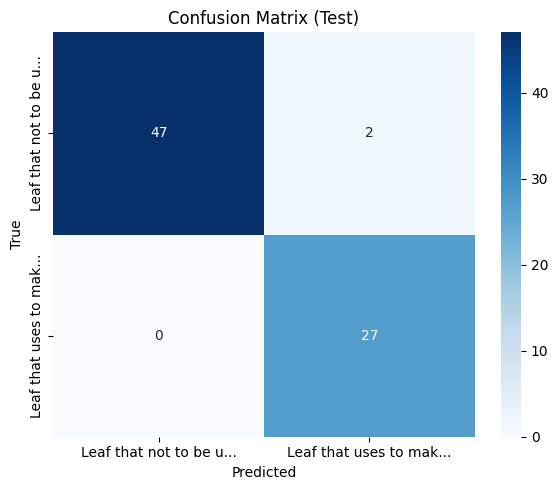

In [58]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names_short, yticklabels=class_names_short, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"))
plt.show()


In [53]:
model_path = os.path.join(OUTPUT_DIR, "resnet50_leaf_model.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'class_to_idx': full_dataset.class_to_idx,
    'orig_class_names': orig_class_names,
    'class_names_short': class_names_short
}, model_path)
print("Saved model checkpoint to:", model_path)


# ========== Generate test predictions & CSV ==========
model.eval()
test_rows = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        for i in range(len(preds)):
            test_rows.append({
                'true_label': orig_class_names[labels[i]],
                'pred_label': orig_class_names[preds[i]]
            })

# Convert to DataFrame and save
preds_df = pd.DataFrame(test_rows)
preds_csv_path = os.path.join(OUTPUT_DIR, "test_predictions.csv")
preds_df.to_csv(preds_csv_path, index=False)

print(f"Saved test predictions CSV to: {preds_csv_path}")


Saved model checkpoint to: /kaggle/working/resnet50_leaf_model.pth
Saved test predictions CSV to: /kaggle/working/test_predictions.csv


**Summary:**

In [55]:

print("==== FINAL REPORT ====")
print("Dataset path:", DATA_DIR)
print("Output path:", OUTPUT_DIR)
print("Classes:", orig_class_names)
print(f"Test set size: {len(test_dataset)}")
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("Files saved to output folder:")
for fname in ["resnet50_leaf_model.pth", "training_history.csv", "loss_curve.png", "accuracy_curve.png", "confusion_matrix.png", "classification_report.csv", "test_predictions.csv"]:
    print(" -", os.path.join(OUTPUT_DIR, fname))


==== FINAL REPORT ====
Dataset path: /kaggle/input/resnet50
Output path: /kaggle/working
Classes: ['Leaf that not to be used to make tea-20251023T175713Z-1-001', 'Leaf that uses to make tea-20251023T175715Z-1-001']
Test set size: 76
Test Accuracy: 0.9868, Precision: 0.9821, Recall: 0.9898, F1: 0.9858
Files saved to output folder:
 - /kaggle/working/resnet50_leaf_model.pth
 - /kaggle/working/training_history.csv
 - /kaggle/working/loss_curve.png
 - /kaggle/working/accuracy_curve.png
 - /kaggle/working/confusion_matrix.png
 - /kaggle/working/classification_report.csv
 - /kaggle/working/test_predictions.csv
